In [31]:
# Check TensorFlow version
import tensorflow as tf
print(tf.__version__) # should be 2.5.0+
import tensorflow_datasets as tfds

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from timeit import default_timer as timer 
assert tf.test.is_gpu_available()
assert tf.test.is_built_with_cuda()

2.9.1


2022-08-03 10:24:21.959543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0


In [19]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

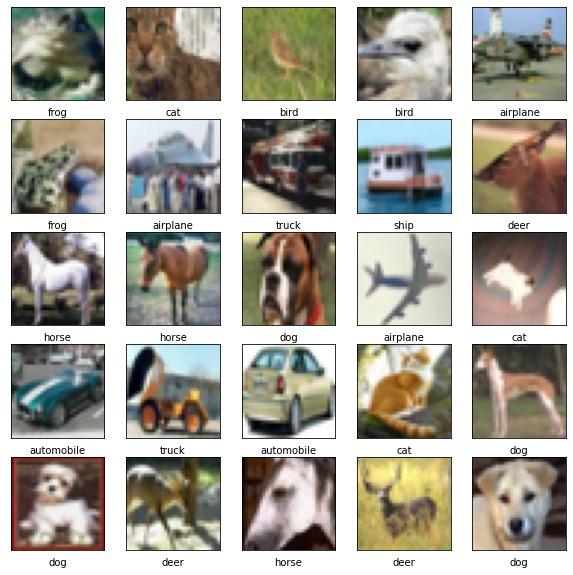

(32, 32, 3)

In [20]:
start = np.random.randint(0,40000)
plt.figure(figsize=(10,10))
for j in range(25):
    i = start + j
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i])
    plt.xlabel(class_names[int(train_labels[i])])
plt.show()
train_images[i].shape

In [21]:
import sys
sys.path.append('/home/me.docker/work/semi_supervised/augment/')
from augment.rand_augment import distort_image_with_randaugment

In [22]:
# distort_image_with_randaugment(train_images[i],num_layers=2,magnitude=7)

In [49]:
import sys
sys.path.append('/home/me.docker/work/semi_supervised/models/')
from resnets import cifar_WRN_28_n, cifar_wide_resnet, Resnet
from resnet_asaf import CIFAR10ResNet18
import json
with open('models/asaf_config.json') as f:
    cofig = json.load(f)

In [50]:
@tf.function
def augment(image, label):
    """ Applies augmentations to the given image. For details on the augmentations please refer to the documentation. """
    # First convert image to floating point representation
    bs = tf.shape(image)[0]
    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_brightness(image, 0.2)

    image = tf.image.random_contrast(image, 1 / 1.3, 1.3)

    image = tf.image.random_hue(image, 0.1)

    image = tf.image.random_saturation(image, 1 / 1.2, 1.2)

    # Randomly increase the size of the image slightly to then randomly crop a part out of it.
    # This is a way to get random scales + translations
    random_height = tf.random.uniform((), minval=32, maxval=40, dtype=tf.int32)
    random_width = tf.random.uniform((), minval=32, maxval=40, dtype=tf.int32)
    image = tf.image.resize(image, (random_height, random_width))
    image = tf.image.random_crop(image, (bs, 32, 32, 3))
    return image, label

In [54]:
BATCH_SIZE = 256

def train_model(epochs = 20, lr=5e-4, use_augment=False, l2_reg=0.0001):
    # Create datasets 
    # flip, whitening, rand crop ( pad 36, crop 32), (optional: cutout, mix)
    train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

    # Make datasets faster
    train_data = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # augment 
    if use_augment:
        # flip = tf.keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),layers.RandomRotation(0.2)])
        train_data = train_data.map(lambda x, y: augment(x, y))
        # train_data = train_data.map(lambda x, y: flip(x, training=True), y)

    scce = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    # model = cifar_wide_resnet(28, 2, 'preactivated', shortcut_type='B', dropout=0.2, l2_reg=0.0001)
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, l2_reg=l2_reg, group_sizes=(3, 3, 3), features=(16, 32, 64),
                   strides=(1, 2, 2), first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, shortcut_type='A', 
                   block_type='original', preact_shortcuts=False)
    # model = CIFAR10ResNet18(config,
    #                         output_dir=self.config["output_dir"],
    #                         input_shape=(32, 32, 3),
    #                         n_classes=10,
    #                         optimizer=self.optimizer,
    #                         weight_decay=self.config["weight_decay"]))
    decay_steps = int(epochs * len(train_data) / BATCH_SIZE)
    model.compile(loss=scce, # since labels aren't one-hot, use sparse_categorical_crossentropy
                  # optimizer=tf.keras.optimizers.Adam(learning_rate=tf.keras.experimental.CosineDecay(lr, decay_steps=decay_steps)), 
                  optimizer=tf.keras.optimizers.Adam(lr),
                  metrics=["accuracy"])

    # Fit model 
    curr_logs = model.fit(train_data,
                        epochs=epochs,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))
    return model, curr_logs

In [27]:
train_data = tf.data.Dataset.from_tensor_slices((train_images[:10], train_labels[:10]))
train_data = train_data.batch(10).prefetch(tf.data.AUTOTUNE)
di = train_data.as_numpy_iterator()
x, y = di.next()
train_data = tf.data.Dataset.from_tensor_slices((train_images[:10], train_labels[:10]))
train_data = train_data.batch(10).prefetch(tf.data.AUTOTUNE)
train_data = train_data.map(lambda x, y: augment(x, y))
di = train_data.as_numpy_iterator()
xa, ya = di.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

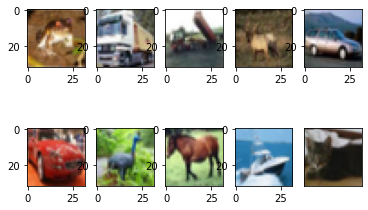

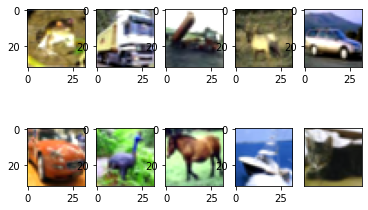

In [28]:
%matplotlib inline
fig, ax = plt.subplots(2,5)
for i in range(10):
    ax[i//5, i%5].imshow(x[i])
    plt.xticks([])
    plt.yticks([])

    
fig, ax = plt.subplots(2,5)
for i in range(10):
    ax[i//5, i%5].imshow(xa[i])
    plt.xticks([])
    plt.yticks([])

In [56]:
no_augment, no_augment_log = train_model(epochs = 20, lr=5e-4, use_augment=False)

Epoch 1/20
196/196 [==============================] - 5s 20ms/step - loss: 1.8536 - accuracy: 0.3952 - val_loss: 2.6900 - val_accuracy: 0.1982
Epoch 2/20
196/196 [==============================] - 4s 18ms/step - loss: 1.3944 - accuracy: 0.5447 - val_loss: 1.6579 - val_accuracy: 0.4409
Epoch 3/20
196/196 [==============================] - 4s 18ms/step - loss: 1.2185 - accuracy: 0.6132 - val_loss: 1.4403 - val_accuracy: 0.5306
Epoch 4/20
196/196 [==============================] - 4s 18ms/step - loss: 1.0915 - accuracy: 0.6608 - val_loss: 1.2872 - val_accuracy: 0.5858
Epoch 5/20
196/196 [==============================] - 3s 18ms/step - loss: 0.9919 - accuracy: 0.6974 - val_loss: 1.2473 - val_accuracy: 0.6085
Epoch 6/20
196/196 [==============================] - 4s 18ms/step - loss: 0.9073 - accuracy: 0.7273 - val_loss: 1.2802 - val_accuracy: 0.6083
Epoch 7/20
196/196 [==============================] - 4s 18ms/step - loss: 0.8331 - accuracy: 0.7564 - val_loss: 1.3279 - val_accuracy: 0.5998

In [58]:
augment_model_5e4, augment_log_5e4 = train_model(epochs=50, lr=5e-3, use_augment=True)
# augment_model_1e4, augment_log_1e4 = train_model(epochs = 20, lr=1e-4, use_augment=True)


Epoch 1/50
196/196 [==============================] - 7s 31ms/step - loss: 1.6930 - accuracy: 0.4431 - val_loss: 3.5739 - val_accuracy: 0.2807
Epoch 2/50
196/196 [==============================] - 6s 30ms/step - loss: 1.2217 - accuracy: 0.6194 - val_loss: 1.6203 - val_accuracy: 0.5098
Epoch 3/50
196/196 [==============================] - 6s 30ms/step - loss: 1.0510 - accuracy: 0.6855 - val_loss: 1.2329 - val_accuracy: 0.6291
Epoch 4/50
196/196 [==============================] - 6s 30ms/step - loss: 0.9438 - accuracy: 0.7296 - val_loss: 1.4072 - val_accuracy: 0.5970
Epoch 5/50
196/196 [==============================] - 6s 29ms/step - loss: 0.8930 - accuracy: 0.7521 - val_loss: 1.2476 - val_accuracy: 0.6515
Epoch 6/50
196/196 [==============================] - 6s 30ms/step - loss: 0.8442 - accuracy: 0.7718 - val_loss: 1.1910 - val_accuracy: 0.6555
Epoch 7/50
196/196 [==============================] - 6s 29ms/step - loss: 0.8178 - accuracy: 0.7824 - val_loss: 1.1452 - val_accuracy: 0.6867

In [37]:
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Make datasets faster
train_data = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# augment 
train_data = train_data.map(lambda x, y: augment(x, y))
new_hist_1e4 = augment_model_1e4.fit(train_data,
                        epochs=30,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

new_hist_5e4 = augment_model_5e4.fit(train_data,
                        epochs=30,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/30
196/196 [==============================] - 9s 44ms/step - loss: 1.0738 - accuracy: 0.7431 - val_loss: 1.1854 - val_accuracy: 0.7210
Epoch 2/30
196/196 [==============================] - 9s 45ms/step - loss: 1.0485 - accuracy: 0.7539 - val_loss: 1.1330 - val_accuracy: 0.7349
Epoch 3/30
196/196 [==============================] - 9s 44ms/step - loss: 1.0288 - accuracy: 0.7594 - val_loss: 1.0888 - val_accuracy: 0.7428
Epoch 4/30
196/196 [==============================] - 9s 44ms/step - loss: 1.0159 - accuracy: 0.7634 - val_loss: 1.1456 - val_accuracy: 0.7311
Epoch 5/30
196/196 [==============================] - 9s 44ms/step - loss: 0.9969 - accuracy: 0.7694 - val_loss: 1.0495 - val_accuracy: 0.7654
Epoch 6/30
196/196 [==============================] - 9s 44ms/step - loss: 0.9793 - accuracy: 0.7752 - val_loss: 1.1180 - val_accuracy: 0.7439
Epoch 7/30
196/196 [==============================] - 9s 45ms/step - loss: 0.9671 - accuracy: 0.7783 - val_loss: 1.0617 - val_accuracy: 0.7613

In [35]:
logs= {"no_aug": no_augment_log, "augment_5e4":augment_log_5e4, "augment_1e4": augment_log_1e4}

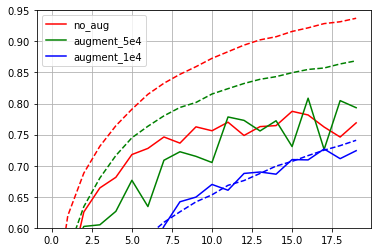

In [36]:
# history.history.keys()
plt.figure()
colors = ['r', 'g', 'b', 'k', 'p']
for lr, c  in zip(logs, colors[:len(logs)]):
    plt.plot(logs[lr].history['val_accuracy'], color=c, label=lr)
    plt.plot(logs[lr].history['accuracy'], color=c, linestyle='--')
plt.grid()
plt.ylim([0.6, 0.95])
plt.legend()